In [145]:
!mkdir  'weights3/'

mkdir: cannot create directory ‘weights3/’: File exists


In [146]:
!pip install gdown

!gdown --id 1Zs93aWxHykVlWvDnh9OAMf1Vb3Adlwej

In [147]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [148]:
import os
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import pickle
from keras.utils import plot_model
from keras.applications.xception import Xception
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.xception import preprocess_input
from keras.models import Model
import string
import numpy as np
from pickle import load
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM ,GRU
from keras.layers import Embedding
from keras.layers import Dropout, Reshape, Lambda, Concatenate
from keras.layers import Concatenate
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from nltk.translate.bleu_score import corpus_bleu
from time import time

emb_dim = 50
snaphot_folder = '/kaggle/working/weights3'
batch_size = 32

In [149]:
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [150]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_set(filenames):
	# process line by line
  dataset= list()
  for filename in filenames:
		# get the image identifier
    identifier = filename.split('.')[0]
    dataset.append(identifier)
  return list(set(dataset))

def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [152]:
doc = load_doc("/kaggle/input/cleaning-results/results.txt")

In [153]:
descriptions = {}
for line in doc.split('\n'):
    try:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)
    except :
        print(line)

In [154]:
descriptions['5500138655']

['0| Two older men in big jackets are playing a game of air hockey together .;',
 '1| Two people wearing coats are playing an "" Airgame "" .";',
 '2| Starting a game of hair hockey between two men .;',
 '3| Two guys wearing coats playing air hockey .;',
 '4| two men playing a ice hockey together;']

1000092795 ['0| Two young guys with shaggy hair look at their hands while hanging out in the yard .;', '1| Two young White males are outside near many bushes .;', '2| Two men in green shirts are standing in a yard .;', '3| A man in a blue shirt standing in a garden .;', '4| Two friends enjoy time spent together .;']


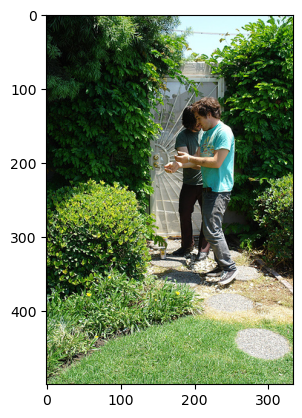

In [155]:
print(next(iter(descriptions)),descriptions[next(iter(descriptions))])

x = plt.imread('/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'+next(iter(descriptions))+'.jpg')
plt.imshow(x)
plt.show()

In [156]:
def clean_data(pairs):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>0]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

    return descriptions

In [157]:
descriptions_clean = clean_data(descriptions)
descriptions[next(iter(descriptions_clean))]

['two young guys with shaggy hair look at their hands while hanging out in the yard',
 'two young white males are outside near many bushes',
 'two men in green shirts are standing in a yard',
 'a man in a blue shirt standing in a garden',
 'two friends enjoy time spent together']

In [158]:
start_token = '<startseq>'
end_token = '<endseq>'
def add_end_start_tokens(descriptions):
    for key in descriptions:
        for i in range(len(descriptions[key])):
            descriptions[key][i] = start_token + ' ' + descriptions[key][i] + ' ' + end_token
    return descriptions

In [159]:
descriptions_tokenSE = add_end_start_tokens(descriptions_clean)
descriptions_tokenSE[next(iter(descriptions_tokenSE))]

['<startseq> two young guys with shaggy hair look at their hands while hanging out in the yard <endseq>',
 '<startseq> two young white males are outside near many bushes <endseq>',
 '<startseq> two men in green shirts are standing in a yard <endseq>',
 '<startseq> a man in a blue shirt standing in a garden <endseq>',
 '<startseq> two friends enjoy time spent together <endseq>']

#### Loading train captions

In [160]:
def load_train_test(descriptions, dataset):
    dataset_ = {}
    for image_id in dataset:
        dataset_[image_id] = descriptions[image_id]

    return dataset_

In [161]:
from os import walk
mypath ='/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
filenames = next(walk(mypath), (None, None, []))[2]

In [162]:
print(type(filenames))

<class 'list'>


In [163]:
print(filenames[0])

2715746315.jpg


In [164]:
idxx=0
for i in range(len(filenames)):
  if '.jpg' in filenames[i]:
    pass
  else:
    idxx=i
    print(i)

26246


In [165]:
x=filenames[idxx]
filenames.remove(x)

In [166]:
split = int(0.8*len(filenames))
filenames_train = filenames[:split]
filenames_testval = filenames[split:]

In [167]:
split = int(0.9*len(filenames_testval))
filenames_test = filenames_testval[:split]
filenames_val = filenames_testval[split:]

In [168]:
print(len(filenames_train))
print(len(filenames_test))
print(len(filenames_val))

25426
5721
636


In [169]:
train_imgs_names = load_set(filenames_train)
test_imgs_names = load_set(filenames_test)
val_imgs_names = load_set(filenames_val)

In [170]:
train_descriptions = load_train_test(descriptions_tokenSE, train_imgs_names)
test_descriptions = load_train_test(descriptions_tokenSE, test_imgs_names)
val_descriptions = load_train_test(descriptions_tokenSE, val_imgs_names)

In [171]:
print(len(train_descriptions))
print(len(test_descriptions))
print(len(val_descriptions))

25426
5721
636


In [172]:
pickle.dump(train_descriptions, open('train_descriptions.pkl', 'wb'))
pickle.dump(test_descriptions, open('test_descriptions.pkl', 'wb'))
pickle.dump(val_descriptions, open('val_descriptions.pkl', 'wb'))

In [173]:
with open('/kaggle/working/train_descriptions.pkl','rb') as f:
    train_descriptions= pickle.load(f)
with open('/kaggle/working/test_descriptions.pkl','rb') as f:
    test_descriptions= pickle.load(f)
with open('/kaggle/working/val_descriptions.pkl','rb') as f:
    val_descriptions= pickle.load(f)

In [174]:
print(train_imgs_names[0])

733729667


In [175]:
print(next(iter(train_descriptions)))

733729667


#### reoccuring vocab

In [176]:
# making a vocabulary of the words that occur more than word_count_threshold time
def create_reoccurring_vocab(descriptions, word_count_threshold = 10):
    # Create a list of all the captions
    all_captions = []
    for key, val in descriptions.items():
        for cap in val:
            all_captions.append(cap)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

    return vocab

In [177]:
vocab = create_reoccurring_vocab(train_descriptions, word_count_threshold = 5)
sorted(vocab)[:10]

['<endseq>',
 '<startseq>',
 'a',
 'aaron',
 'abandoned',
 'able',
 'aboard',
 'about',
 'above',
 'abstract']

In [178]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
tokenizer = keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
tokenizer.fit_on_texts(vocab)
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size :', vocab_size)

vocab_size : 6986


In [179]:
ixtoword = {} # index to word dic
wordtoix = {} # word to index dic

tokenizer.word_index['<PAD0>'] = 0 # no word in vocab has index 0. but padding is indicated with 0
wordtoix = tokenizer.word_index # word to index dic

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

#### finding suitable length for sequences to use in training

In [180]:
# finding the maximum length of questions and answers
# because there are senteces with unusually long lengths,
# we caculate the max length that p% of data can be placed in
def max_length(desc,p):
    all_desc = []
    # Create a list of all the captions
    for i in desc:
        for j in desc[i]:
            all_desc.append(j)

    length_all_desc = list(len(d.split()) for d in all_desc)

    print('percentile {} of len of questions: {}'.format(p,np.percentile(length_all_desc, p)))
    print('longest sentence: ', max(length_all_desc))

    return int(np.percentile(length_all_desc, p))

max_length = max_length(train_descriptions,90)

print('max-len answer for training: ', max_length)

percentile 90 of len of questions: 21.0
longest sentence:  80
max-len answer for training:  21


In [181]:
# only keep the decriptions that have the words from our vocab
def trimRareWords(desc):
    num_des = 0
    num_trim = 0
    desc_result = desc.copy()
    for d in desc_result:
        desc_result[d]=[]

    # Filter out pairs with trimmed words
    i=0
    for d in desc:
        i+=1
        progressBar(value=i, endvalue=len(desc))
        for p in desc[d]:
            num_des += 1
            keep_input = True
            # Check input sentence
            for word in p.split(' '):
                if word not in vocab:
                    keep_input = False
                    break

            # Only keep descriptions that do not contain trimmed word(s) in them
            if keep_input:
                num_trim += 1
                desc_result[d].append(p)

    print("\nTrimmed from {} pairs to {}".format(num_des, num_trim))
    return desc_result


# Trim voc and pairs
# desc_train_final = trimRareWords(train_descriptions)
# with open ('train_descriptions.pkl','wb') as f:
#     pickle.dump(desc_train_final,f)

# with open ('train_descriptions.pkl','rb') as f:
#     desc_train_final = pickle.load(f)

# len(desc_train_final)

#### feature extractor model Xception

In [182]:
xception = Xception()
extractor = Model(inputs=xception.inputs, outputs=xception.layers[-2].output) # removing 2 last fully connected layers
print(extractor.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [183]:
def extract_features(description, model, inpute_size = (299,299)):
    directory = '/content/flickr30k_images/flickr30k_images'
    features = {}
    i = 0
    for name in description:
        progressBar(value=i,endvalue=len(descriptions))
        i +=1
        filename =os.path.join(directory, name+'.jpg')
        image = load_img(filename, target_size=inpute_size)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature.reshape(2048)
    return features

train_features = extract_features(train_descriptions, extractor)

pickle.dump(train_features, open('train_features.pkl', 'wb'))




In [185]:
with open('/kaggle/input/xception-feat/train_features.pkl','rb') as f:
    t= pickle.load(f)

In [186]:
train_features={}
for name in train_imgs_names:
    train_features[name]=t[name]

In [187]:
test_features={}
for name in test_imgs_names:
    test_features[name]=t[name]

In [188]:
val_features={}
for name in val_imgs_names:
    val_features[name]=t[name]

In [189]:
len(train_features),len(test_features),len(val_features)

(25426, 5721, 636)

#### Data Genarator

In [190]:
# outputs a batch of captions-pictures
def data_generator(descriptions, photos):
    X1, X2, y = [], [], []
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # find the index of each word of the caption in vocabulary
                seq = tokenizer.texts_to_sequences(desc.split())
                # split one sequence into multiple X, y pairs
                # Each step of the following for loop selects one word
                # from the caption, consider that word as y and
                # all the words before that will be the X
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i] # words until i are inseq word i is outseq
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == batch_size:
                yield [[np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1)]
                X1, X2, y = list(), list(), list()
                n=0

In [191]:
d = next(data_generator(train_descriptions, train_features))
d[0][0].shape, d[0][1].shape, d[1].shape

((2124, 2048), (2124, 21), (2124,))

#### Word Emeddings glove

import requests
file_url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip"

r = requests.get(file_url, stream = True)

with open("/kaggle/working/glove.6B.zip", "wb") as file:
    for block in r.iter_content(chunk_size = 1024):
         if block:
             file.write(block)

!unzip /kaggle/working/glove.6B.zip

In [192]:
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # just a zero matrix
    else:
        glove_dir = '/kaggle/working/'
        embeddings_index = {}
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get x-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        print('GloVe loaded!')

    embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])

    return embedding_layer

In [193]:
# in order to make model faster, I load embd outside the make_model
embedding_layer = make_embedding_layer(emb_dim, glove=True)

GloVe loaded!


# Loss

In [194]:
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

#### Constructing the model

In [195]:
from keras.layers import RepeatVector
def make_model(embedding ,dout= 0.2, feature_size= 2048, units= 256):

    features = Input(shape=(feature_size,)) # output size of feature extractor
    X_fe_one_dim = Dense(units, activation='relu')(features) # because i have used bidirectional LSTM, the number of units should
                                                   # become double here in order for the add function to work
    X_fe = RepeatVector(max_length)(X_fe_one_dim)
    X_fe = Dropout(dout)(X_fe)

    seq = Input(shape=(max_length,))
    X_seq = embedding(seq)
    X_seq = Lambda(lambda x: x, output_shape=lambda s:s)(X_seq) # remove mask from the embedding cause concat doesn't support it
    X_seq = Dropout(dout)(X_seq)
    X_seq = Concatenate(name='concat_features_word_embeddings', axis=-1)([X_fe,X_seq])
    X_seq = GRU(units, return_sequences=True)(X_seq,initial_state=X_fe_one_dim) # passing features as init_state
    X_seq = Dropout(dout + 0.2)(X_seq)
    X_seq = GRU(units, return_sequences=False)(X_seq)

    outputs = Dense(vocab_size, activation='softmax')(X_seq)

    # merge the two input models
    model = Model(inputs=[features, seq], outputs = outputs, name='model_with_features_each_step')
    return model

In [196]:
model = make_model(embedding_layer)
model.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 256)          524544      ['input_8[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 21, 50)       349300      ['input_9[0][0]']                
                                                                      

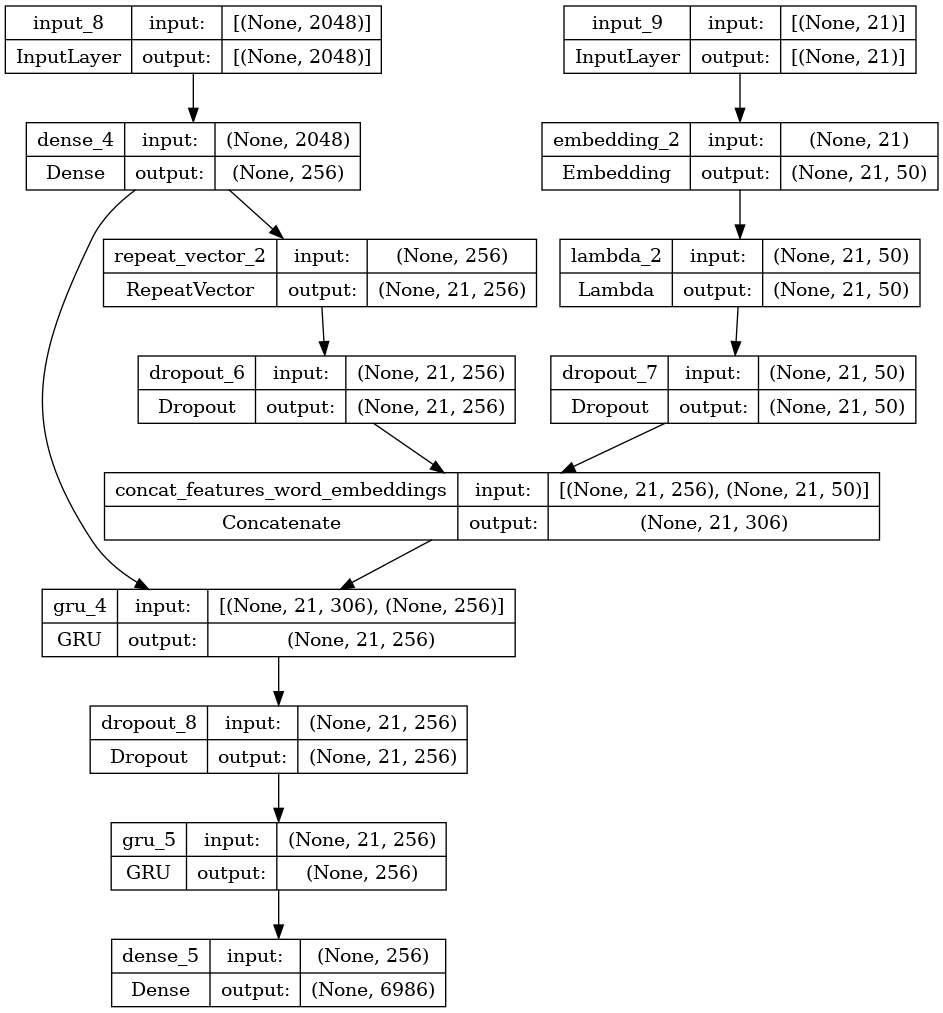

In [197]:
plot_model(model, to_file='model3.png', show_shapes=True)

In [198]:
model.compile(loss=masked_loss_function, optimizer= 'adam')

In [199]:
history={'loss':[], 'BLEU_val':[]}

In [200]:
# generate a description for an image greedy way
def generate_desc(model, photo_fe, inference= False):
    # seed the generation process
    in_text = start_token
    # iterate over the whole length of the sequence
    # generate one word at each iteratoin of the loop
    # appends the new word to a list and makes the whole sentence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences(in_text.split()) #[wordtoix[w] for w in in_text.split() if w in wordtoix]
        # pad input
        photo_fe = photo_fe.reshape((1,2048))
        sequence = pad_sequences([sequence], maxlen=max_length).reshape((1,max_length))
        # predict next word
        yhat = model.predict([photo_fe,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next v
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == end_token:
            break

    if inference == True:
        in_text = in_text.split()
        if len(in_text) == max_length:
            in_text = in_text[1:] # if it is already at max len and endseq hasn't appeared
        else:
            in_text = in_text[1:-1]
        in_text = ' '.join(in_text)

    return in_text

In [201]:
def beam_search_pred(model, pic_fe, wordtoix, K_beams = 3, log = False):
    start = [wordtoix[start_token]]

    start_word = [[start, 0.0]]

    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words
                                                                                         # based on the previous steps
            preds = model.predict([pic_fe.reshape(1,2048), sequence],verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                         # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:

                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]

    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []

    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [202]:
# calculating BLEU score of predictions
def evaluate_model(model, descriptions, photos_fe, K_beams= 3, log=False):
    actual, predicted = list(), list()
    b1=0
    b2=0
    b3=0
    b4=0
    # step over the whole set
    i=0
    for key, desc_list in descriptions.items():
        # generate description
        i+=1
        progressBar(i, len(descriptions), bar_length=20,job='Evaluating')
        if K_beams == 1:
            yhat = generate_desc(model, photos_fe[key])
        else:
            yhat=beam_search_pred(model, photos_fe[key], wordtoix, K_beams = K_beams,log=log)

        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())

    # calculate BLEU score
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1,b2,b3,b4]

In [203]:
from keras.callbacks import ReduceLROnPlateau
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)

====


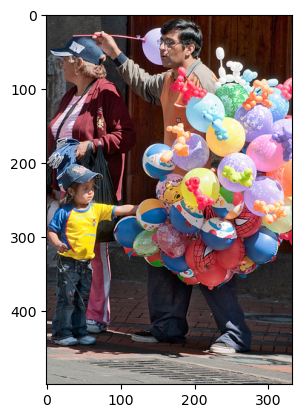

Greedy: coveralls loaded loaded sweeps sweeps mats mats patterned mats patterned viewing mats mats patterned viewing mats pray patterned loaded something


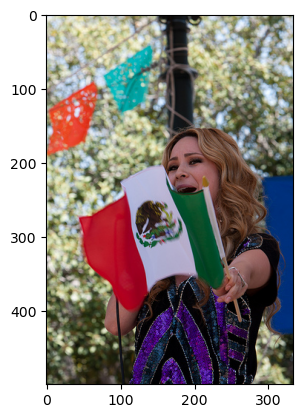

Greedy: toronto hugs hugs barred barred barred barred practicing practicing sunbathers chestnut oxen oxen oxen oxen oxen oxen oxen oxen oxen


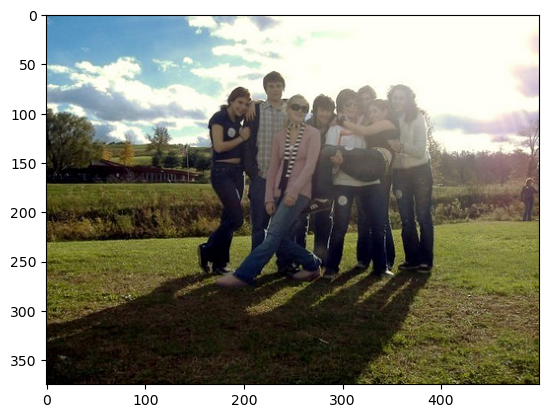

Greedy: huts scottish scottish trough been practicing practicing practicing pews practicing flowers flowers automobiles scottish scottish trunks beijing pews pews patterned


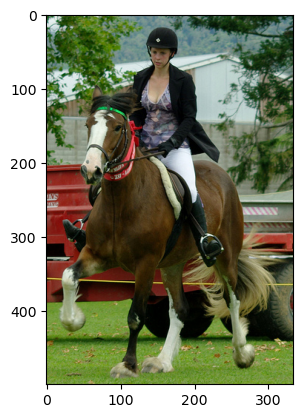

Greedy: punk fiddle descending chestnut equipment caucasian tripods tripods chestnut chestnut yamaha descending equipment tripods chestnut disaster parade carrying scooters highchair
====


In [204]:
def test(i=np.random.randint(len(test_features)), j=np.random.randint(len(test_features)),
         k=np.random.randint(len(test_features)), q=np.random.randint(len(test_features)), show_pic=False):
    print('====')
    pic = list(test_features.keys())[i]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))

    pic = list(test_features.keys())[j]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))

    pic = list(test_features.keys())[k]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:", generate_desc(model, fe, inference=True))
    pic = list(test_features.keys())[q]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))

    print('====')


test(show_pic=True)

In [205]:
steps = len(train_descriptions)//batch_size
generator = data_generator(train_descriptions, train_features)
ep=1

In [213]:
from keras.models import load_model
model1=load_model('/kaggle/input/full-model/full_model.h5',compile = False)

In [214]:
model1.compile(loss=masked_loss_function, optimizer= 'adam')

In [ ]:
for i in range(1, 21):

    print('Epoch :',i,'\n')
    # fit for one epoch
    h = model1.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])

    # save model every 3 epochs
    if i % 10 == 0:
        test()
        model1.save_weights(snaphot_folder+'/model_' + str(i) + '.h5')
        belus= evaluate_model(model, val_descriptions, val_features, K_beams=1)
        history['BLEU_val'].append((belus,i))

    print('\n','='*80)

model.save('/kaggle/working/final_model+.h5')

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
len(history['loss'])

In [ ]:
history['BLEU_val']

In [210]:
from keras.models import load_model
model1=load_model('/kaggle/input/full-model/full_model.h5',compile = False)

In [211]:
model1.compile(loss=masked_loss_function, optimizer= 'adam')

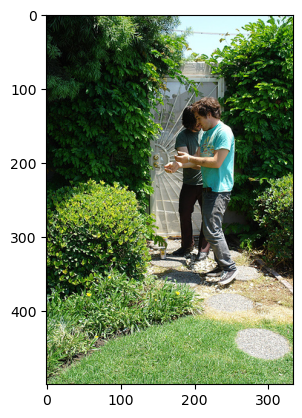

Greedy: jazz wrap couples cats balloons aircraft aircraft aircraft arranged arranged arranged bartender policeman aircraft aircraft aircraft arranged arranged arranged aircraft
Beam K= 3: jazz couples cats aircraft aircraft aircraft aircraft arranged aircraft arranged arranged aircraft aircraft aircraft arranged aircraft arranged aircraft arranged arranged
Beam K= 5: jazz jazz couples encouraging cats aircraft aircraft aircraft aircraft arranged aircraft arranged aircraft arranged aircraft aircraft arranged aircraft aircraft arranged
Beam log K= 3: jazz couples cats aircraft aircraft aircraft aircraft arranged aircraft arranged arranged aircraft aircraft aircraft arranged aircraft arranged aircraft arranged arranged
Beam log K= 5: jazz jazz couples encouraging cats aircraft aircraft aircraft aircraft arranged aircraft arranged aircraft arranged aircraft aircraft arranged aircraft aircraft arranged


In [212]:
test_image='/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg'
image = load_img(test_image, target_size=(299,299))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
fe = extractor.predict(image, verbose=0)
fe = fe.reshape((1,2048))
x=plt.imread(test_image)
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, fe, wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, fe, wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, fe, wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, fe, wordtoix, K_beams = 5, log=True))